## Bibiliothèque

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from resnet import resnet_layer, resnet_v1
from Distiller import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

%matplotlib inline
seed = tf.random.set_seed(10)


2022-05-11 16:46:54.640512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 16:46:54.640568: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Utils

In [2]:
def plot_hist_kd(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['student_loss'], label = "student Loss")
    plt.plot(hist.history['val_student_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [3]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Loading Resnet26 Teacher model

In [4]:
print("")
print("================ Loading teacher model ================")
teacher = tf.keras.models.load_model("Resnet26_from_logits_datagen")
print("Evaluation of Teacher model!")
teacher.evaluate(x_test, y_test)
print("")



================ Loading teacher model ================


2022-05-11 16:47:02.833191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-11 16:47:02.833226: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-11 16:47:02.833273: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tall12): /proc/driver/nvidia/version does not exist
2022-05-11 16:47:02.833625: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Evaluation of Teacher model!
313/313 [==============================] - 12s 35ms/step - loss: 0.4362 - sparse_categorical_accuracy: 0.9084



## Creating a data augmentation process

In [5]:
print("================ Building dataGen ================")
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(x_train)

================ Building dataGen ================


## Building callbacks

In [6]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_student_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_student_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)


## Knowledge distillation

In [7]:
BATCH_SIZE = 32
EPOCHS = 100
T = [5, 10, 15, 20, 25, 30, 35, 40]
lr = 0.1

Epoch 1/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.3706 - student_loss: 1.8274 - loss: 0.8940 - val_sparse_categorical_accuracy: 0.3856 - val_student_loss: 4.5521 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 87s 55ms/step - sparse_categorical_accuracy: 0.4906 - student_loss: 1.5640 - loss: 0.7270 - val_sparse_categorical_accuracy: 0.4843 - val_student_loss: 1.5655 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 88s 55ms/step - sparse_categorical_accuracy: 0.5436 - student_loss: 1.4341 - loss: 0.6504 - val_sparse_categorical_accuracy: 0.5057 - val_student_loss: 2.5131 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 88s 55ms/step - sparse_categorical_accuracy: 0.5769 - student_loss: 1.3409 - loss: 0.5966 - val_sparse_categorical_accuracy: 0.5101 - val_student_loss: 3.4820 - lr: 0.1000
Epoch 5/100
1562/1562 [==============================] - 87s 54ms/step - sparse_cate

Epoch 35/100
1562/1562 [==============================] - 96s 59ms/step - sparse_categorical_accuracy: 0.7753 - student_loss: 0.7110 - loss: 0.2941 - val_sparse_categorical_accuracy: 0.7700 - val_student_loss: 2.4349 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 93s 58ms/step - sparse_categorical_accuracy: 0.7761 - student_loss: 0.7110 - loss: 0.2941 - val_sparse_categorical_accuracy: 0.7701 - val_student_loss: 2.4420 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 92s 57ms/step - sparse_categorical_accuracy: 0.7761 - student_loss: 0.7132 - loss: 0.2947 - val_sparse_categorical_accuracy: 0.7686 - val_student_loss: 2.4505 - lr: 1.0000e-03
Epoch 38/100
1562/1562 [==============================] - 92s 57ms/step - sparse_categorical_accuracy: 0.7749 - student_loss: 0.7161 - loss: 0.2957 - val_sparse_categorical_accuracy: 0.7653 - val_student_loss: 2.4428 - lr: 1.0000e-03
Epoch 39/100
1562/1562 [==============================] - 93s 58

1562/1562 [==============================] - 93s 58ms/step - sparse_categorical_accuracy: 0.7794 - student_loss: 0.7083 - loss: 0.2923 - val_sparse_categorical_accuracy: 0.7686 - val_student_loss: 2.4471 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 91s 56ms/step - sparse_categorical_accuracy: 0.7760 - student_loss: 0.7117 - loss: 0.2935 - val_sparse_categorical_accuracy: 0.7686 - val_student_loss: 2.4503 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 93s 58ms/step - sparse_categorical_accuracy: 0.7763 - student_loss: 0.7049 - loss: 0.2919 - val_sparse_categorical_accuracy: 0.7697 - val_student_loss: 2.4501 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 92s 56ms/step - sparse_categorical_accuracy: 0.7815 - student_loss: 0.6972 - loss: 0.2909 - val_sparse_categorical_accuracy: 0.7720 - val_student_loss: 2.4510 - lr: 1.0000e-06
Epoch 71/100
1562/1562 [==============================] - 92s 56ms/step - spa

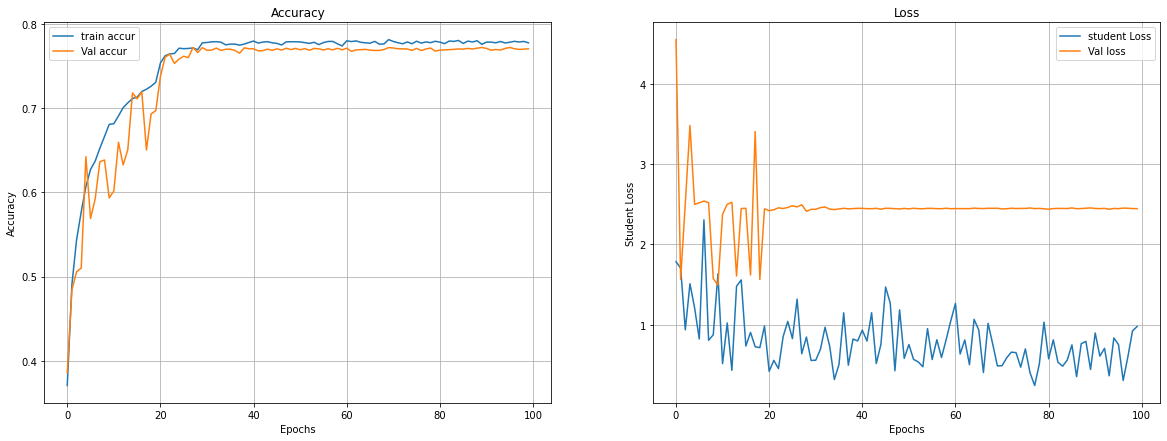

Saving model 


2022-05-11 19:20:33.426875: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.2_temp_5/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 96s 57ms/step - sparse_categorical_accuracy: 0.3779 - student_loss: 1.7137 - loss: 0.5155 - val_sparse_categorical_accuracy: 0.4045 - val_student_loss: 3.5093 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 99s 61ms/step - sparse_categorical_accuracy: 0.4932 - student_loss: 1.4381 - loss: 0.4267 - val_sparse_categorical_accuracy: 0.3742 - val_student_loss: 4.3456 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 86s 52ms/step - sparse_categorical_accuracy: 0.5418 - student_loss: 1.3137 - loss: 0.3881 - val_sparse_categorical_accuracy: 0.5322 - val_student_loss: 2.5331 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 91s 56ms/step - sparse_categorical_accuracy: 0.5719 - student_loss: 1.2411 - loss: 0.3639 - val_sparse_categorical_accuracy: 0.5443 - v

1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7804 - student_loss: 0.6505 - loss: 0.1854 - val_sparse_categorical_accuracy: 0.7752 - val_student_loss: 2.4354 - lr: 0.0100
Epoch 36/100
1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.7785 - student_loss: 0.6532 - loss: 0.1855 - val_sparse_categorical_accuracy: 0.7780 - val_student_loss: 2.4247 - lr: 0.0100
Epoch 37/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7824 - student_loss: 0.6456 - loss: 0.1838 - val_sparse_categorical_accuracy: 0.7627 - val_student_loss: 2.4345 - lr: 0.0100
Epoch 38/100
1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.7812 - student_loss: 0.6456 - loss: 0.1840 - val_sparse_categorical_accuracy: 0.7871 - val_student_loss: 2.4259 - lr: 0.0100
Epoch 39/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accura

1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.7894 - student_loss: 0.6235 - loss: 0.1781 - val_sparse_categorical_accuracy: 0.7754 - val_student_loss: 2.4384 - lr: 1.0000e-05
Epoch 68/100
1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.7893 - student_loss: 0.6194 - loss: 0.1776 - val_sparse_categorical_accuracy: 0.7766 - val_student_loss: 2.4337 - lr: 1.0000e-05
Epoch 69/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.7862 - student_loss: 0.6337 - loss: 0.1802
Epoch 69: ReduceLROnPlateau reducing learning rate to 1e-06.
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7862 - student_loss: 0.6337 - loss: 0.1801 - val_sparse_categorical_accuracy: 0.7776 - val_student_loss: 2.4363 - lr: 1.0000e-05
Epoch 70/100
1562/1562 [==============================] - 94s 56ms/step - sparse_categorical_accuracy: 0.7866 - student_l

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.7768 - student_loss: 1.6345

 =============== History Plot ===============


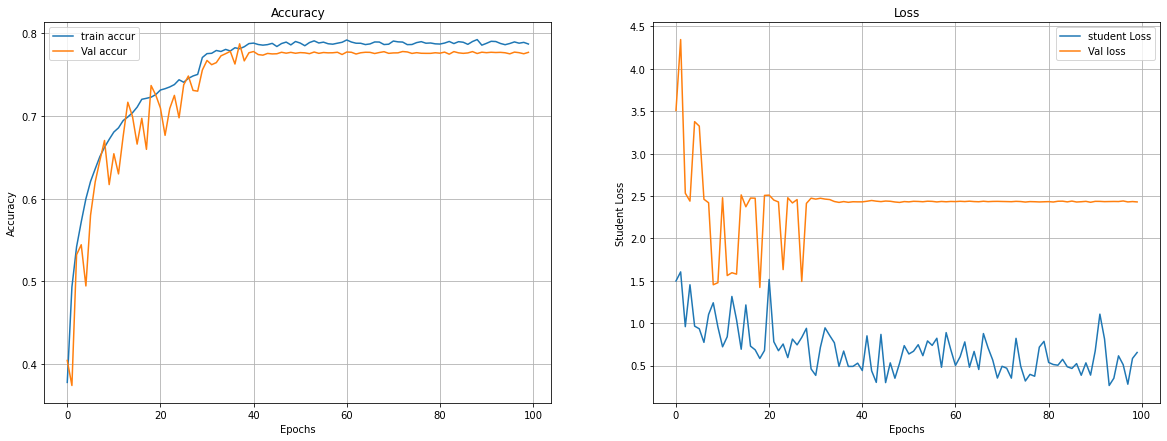

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.2_temp_10/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 95s 56ms/step - sparse_categorical_accuracy: 0.3803 - student_loss: 1.6922 - loss: 0.4145 - val_sparse_categorical_accuracy: 0.3481 - val_student_loss: 3.3667 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 90s 54ms/step - sparse_categorical_accuracy: 0.4924 - student_loss: 1.4122 - loss: 0.3463 - val_sparse_categorical_accuracy: 0.4185 - val_student_loss: 3.4018 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.5439 - student_loss: 1.2843 - loss: 0.3147 - val_sparse_categorical_accuracy: 0.4601 - val_student_loss: 3.3947 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 96s 59ms/step - sparse_categorical_accuracy: 0.5713 - student_loss: 1.2156 - loss: 0.2973 - val_sparse_categorical_accur

1562/1562 [==============================] - 90s 55ms/step - sparse_categorical_accuracy: 0.7623 - student_loss: 0.6898 - loss: 0.1678 - val_sparse_categorical_accuracy: 0.7476 - val_student_loss: 2.4127 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 89s 54ms/step - sparse_categorical_accuracy: 0.7610 - student_loss: 0.6910 - loss: 0.1679 - val_sparse_categorical_accuracy: 0.7500 - val_student_loss: 2.4109 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 91s 56ms/step - sparse_categorical_accuracy: 0.7625 - student_loss: 0.6891 - loss: 0.1677 - val_sparse_categorical_accuracy: 0.7483 - val_student_loss: 2.4141 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 92s 57ms/step - sparse_categorical_accuracy: 0.7621 - student_loss: 0.6903 - loss: 0.1677 - val_sparse_categorical_accuracy: 0.7501 - val_student_loss: 2.4046 - lr: 1.0000e-03
Epoch 37/100
1563/1562 [==============================] - ETA: 0s - sparse_ca

1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7610 - student_loss: 0.6906 - loss: 0.1677 - val_sparse_categorical_accuracy: 0.7487 - val_student_loss: 2.4122 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 92s 56ms/step - sparse_categorical_accuracy: 0.7644 - student_loss: 0.6843 - loss: 0.1666 - val_sparse_categorical_accuracy: 0.7506 - val_student_loss: 2.4142 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.7631 - student_loss: 0.6861 - loss: 0.1670 - val_sparse_categorical_accuracy: 0.7488 - val_student_loss: 2.4161 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.7594 - student_loss: 0.6934 - loss: 0.1682 - val_sparse_categorical_accuracy: 0.7502 - val_student_loss: 2.4170 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 93s 56ms/step - spa

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.7517 - student_loss: 1.7181

 =============== History Plot ===============


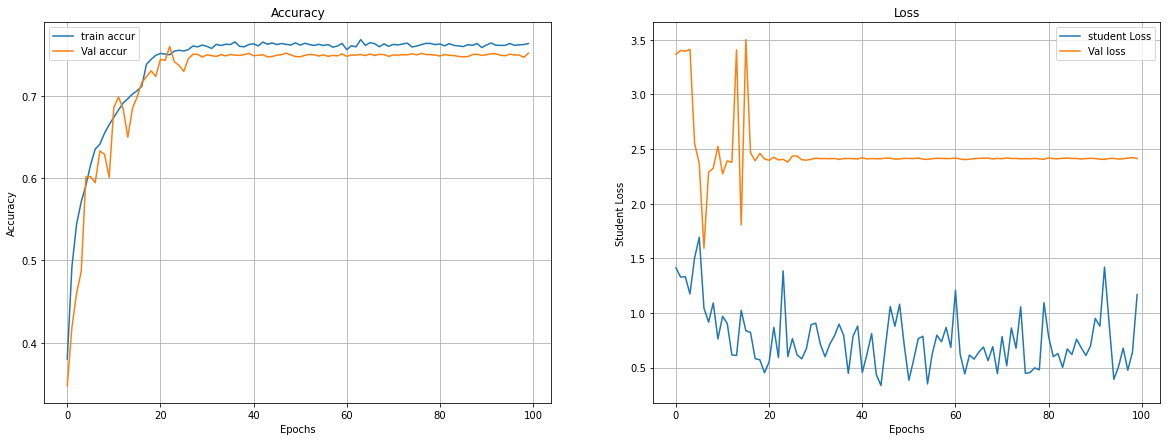

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.2_temp_15/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 100s 59ms/step - sparse_categorical_accuracy: 0.3779 - student_loss: 1.6890 - loss: 0.3793 - val_sparse_categorical_accuracy: 0.3240 - val_student_loss: 1.4899 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.4866 - student_loss: 1.4186 - loss: 0.3195 - val_sparse_categorical_accuracy: 0.4666 - val_student_loss: 2.4508 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 98s 59ms/step - sparse_categorical_accuracy: 0.5333 - student_loss: 1.3057 - loss: 0.2939 - val_sparse_categorical_accuracy: 0.4800 - val_student_loss: 3.5798 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 98s 59ms/step - sparse_categorical_accuracy: 0.5719 - student_loss: 1.2131 - loss: 0.2737 - val_sparse_categorical_accu

1562/1562 [==============================] - 98s 59ms/step - sparse_categorical_accuracy: 0.7647 - student_loss: 0.6783 - loss: 0.1522 - val_sparse_categorical_accuracy: 0.7580 - val_student_loss: 1.5362 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7663 - student_loss: 0.6774 - loss: 0.1522 - val_sparse_categorical_accuracy: 0.7533 - val_student_loss: 1.5399 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.7668 - student_loss: 0.6713 - loss: 0.1509 - val_sparse_categorical_accuracy: 0.7531 - val_student_loss: 1.6252 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7691 - student_loss: 0.6676 - loss: 0.1502 - val_sparse_categorical_accuracy: 0.7517 - val_student_loss: 1.6525 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 95s 57ms/step - spa

1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.7675 - student_loss: 0.6670 - loss: 0.1499 - val_sparse_categorical_accuracy: 0.7540 - val_student_loss: 1.5805 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 98s 59ms/step - sparse_categorical_accuracy: 0.7708 - student_loss: 0.6596 - loss: 0.1486 - val_sparse_categorical_accuracy: 0.7542 - val_student_loss: 1.5931 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7669 - student_loss: 0.6699 - loss: 0.1505 - val_sparse_categorical_accuracy: 0.7553 - val_student_loss: 1.5899 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7650 - student_loss: 0.6730 - loss: 0.1512 - val_sparse_categorical_accuracy: 0.7545 - val_student_loss: 1.5786 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 96s 58ms/step - spa

313/313 [==============================] - 4s 13ms/step - sparse_categorical_accuracy: 0.7553 - student_loss: 1.7173

 =============== History Plot ===============


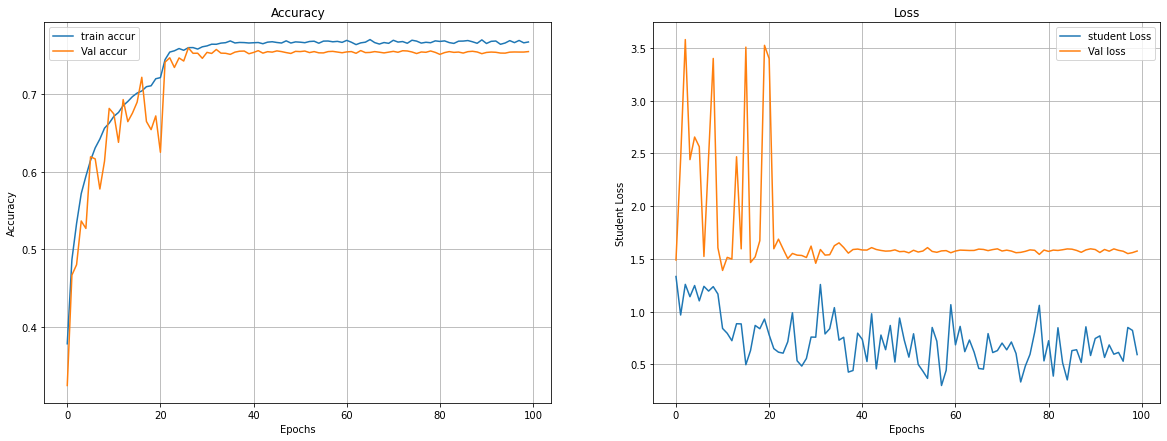

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.2_temp_20/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 97s 56ms/step - sparse_categorical_accuracy: 0.3757 - student_loss: 1.6994 - loss: 0.3659 - val_sparse_categorical_accuracy: 0.2547 - val_student_loss: 4.5121 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 92s 55ms/step - sparse_categorical_accuracy: 0.4887 - student_loss: 1.4030 - loss: 0.3028 - val_sparse_categorical_accuracy: 0.3128 - val_student_loss: 3.6354 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 90s 55ms/step - sparse_categorical_accuracy: 0.5425 - student_loss: 1.2854 - loss: 0.2776 - val_sparse_categorical_accuracy: 0.4120 - val_student_loss: 2.5259 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 92s 55ms/step - sparse_categorical_accuracy: 0.5742 - student_loss: 1.1992 - loss: 0.2590 - val_sparse_categorical_accur

Epoch 34/100
1562/1562 [==============================] - 96s 57ms/step - sparse_categorical_accuracy: 0.7743 - student_loss: 0.6502 - loss: 0.1406 - val_sparse_categorical_accuracy: 0.7652 - val_student_loss: 2.3688 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 98s 58ms/step - sparse_categorical_accuracy: 0.7767 - student_loss: 0.6457 - loss: 0.1398 - val_sparse_categorical_accuracy: 0.7670 - val_student_loss: 2.3584 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 101s 60ms/step - sparse_categorical_accuracy: 0.7790 - student_loss: 0.6407 - loss: 0.1387 - val_sparse_categorical_accuracy: 0.7657 - val_student_loss: 2.3624 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.7795 - student_loss: 0.6399 - loss: 0.1384 - val_sparse_categorical_accuracy: 0.7653 - val_student_loss: 2.3616 - lr: 1.0000e-03
Epoch 38/100
1562/1562 [==============================] - 100s 

1562/1562 [==============================] - 96s 57ms/step - sparse_categorical_accuracy: 0.7787 - student_loss: 0.6406 - loss: 0.1385 - val_sparse_categorical_accuracy: 0.7673 - val_student_loss: 2.3666 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7805 - student_loss: 0.6348 - loss: 0.1373 - val_sparse_categorical_accuracy: 0.7651 - val_student_loss: 2.3640 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.7788 - student_loss: 0.6415 - loss: 0.1386 - val_sparse_categorical_accuracy: 0.7691 - val_student_loss: 2.3653 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.7809 - student_loss: 0.6385 - loss: 0.1381 - val_sparse_categorical_accuracy: 0.7704 - val_student_loss: 2.3666 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 96s 57ms/step - spa

313/313 [==============================] - 4s 11ms/step - sparse_categorical_accuracy: 0.7672 - student_loss: 1.6657

 =============== History Plot ===============


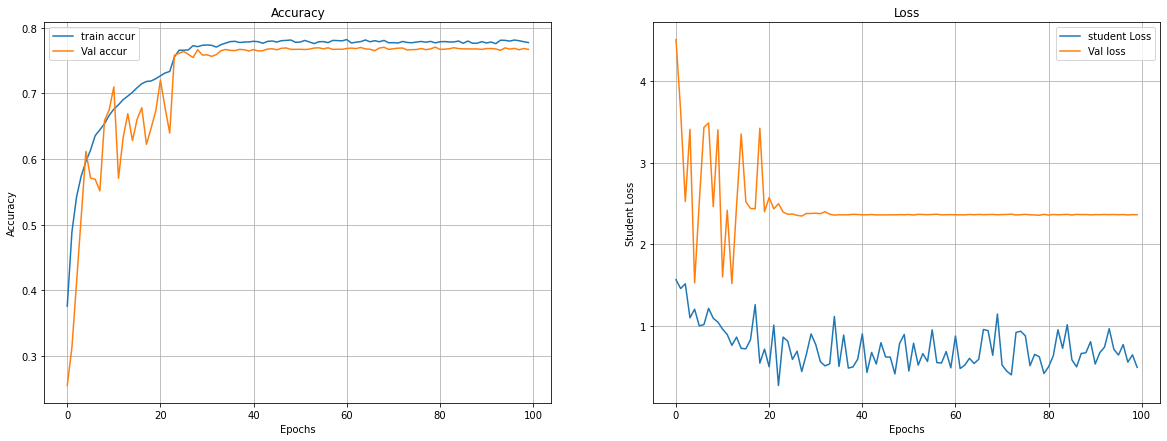

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.2_temp_25/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 104s 60ms/step - sparse_categorical_accuracy: 0.3798 - student_loss: 1.6868 - loss: 0.3548 - val_sparse_categorical_accuracy: 0.3750 - val_student_loss: 1.5267 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.4875 - student_loss: 1.4124 - loss: 0.2976 - val_sparse_categorical_accuracy: 0.3901 - val_student_loss: 2.5216 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 95s 56ms/step - sparse_categorical_accuracy: 0.5355 - student_loss: 1.2889 - loss: 0.2719 - val_sparse_categorical_accuracy: 0.4250 - val_student_loss: 3.4193 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.5677 - student_loss: 1.2123 - loss: 0.2557 - val_sparse_categorical_accu

Epoch 34/100
1562/1562 [==============================] - 96s 57ms/step - sparse_categorical_accuracy: 0.7662 - student_loss: 0.6733 - loss: 0.1422 - val_sparse_categorical_accuracy: 0.7589 - val_student_loss: 2.4313 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 94s 56ms/step - sparse_categorical_accuracy: 0.7713 - student_loss: 0.6637 - loss: 0.1404 - val_sparse_categorical_accuracy: 0.7555 - val_student_loss: 2.4361 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 96s 57ms/step - sparse_categorical_accuracy: 0.7679 - student_loss: 0.6632 - loss: 0.1403 - val_sparse_categorical_accuracy: 0.7575 - val_student_loss: 2.4266 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 96s 57ms/step - sparse_categorical_accuracy: 0.7727 - student_loss: 0.6591 - loss: 0.1395 - val_sparse_categorical_accuracy: 0.7571 - val_student_loss: 2.4265 - lr: 1.0000e-03
Epoch 38/100
1562/1562 [==============================] - 94s 56

1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.7710 - student_loss: 0.6593 - loss: 0.1394 - val_sparse_categorical_accuracy: 0.7580 - val_student_loss: 2.4320 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 96s 57ms/step - sparse_categorical_accuracy: 0.7705 - student_loss: 0.6597 - loss: 0.1395 - val_sparse_categorical_accuracy: 0.7587 - val_student_loss: 2.4209 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.7727 - student_loss: 0.6556 - loss: 0.1387 - val_sparse_categorical_accuracy: 0.7560 - val_student_loss: 2.4297 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 96s 57ms/step - sparse_categorical_accuracy: 0.7744 - student_loss: 0.6578 - loss: 0.1391 - val_sparse_categorical_accuracy: 0.7594 - val_student_loss: 2.4314 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 99s 59ms/step - spa

313/313 [==============================] - 4s 14ms/step - sparse_categorical_accuracy: 0.7561 - student_loss: 1.7045

 =============== History Plot ===============


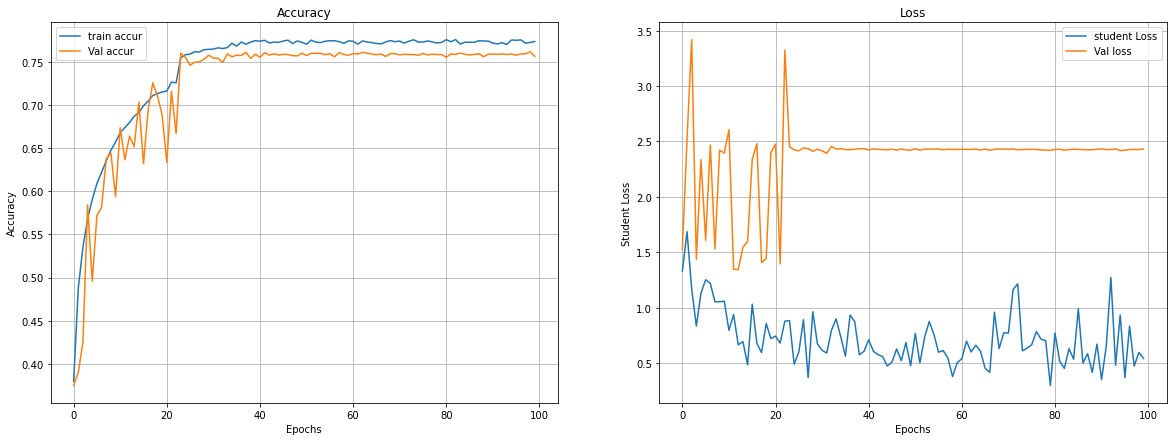

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.2_temp_30/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 95s 56ms/step - sparse_categorical_accuracy: 0.3723 - student_loss: 1.7090 - loss: 0.3545 - val_sparse_categorical_accuracy: 0.3045 - val_student_loss: 3.4356 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.4760 - student_loss: 1.4443 - loss: 0.3000 - val_sparse_categorical_accuracy: 0.5070 - val_student_loss: 1.4014 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.5321 - student_loss: 1.3038 - loss: 0.2710 - val_sparse_categorical_accuracy: 0.5557 - val_student_loss: 2.4654 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 94s 56ms/step - sparse_categorical_accuracy: 0.5647 - student_loss: 1.2257 - loss: 0.2549 - val_sparse_categorical_accur

Epoch 33/100
1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.7379 - student_loss: 0.7533 - loss: 0.1571 - val_sparse_categorical_accuracy: 0.7311 - val_student_loss: 2.4037 - lr: 1.0000e-04
Epoch 34/100
1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.7383 - student_loss: 0.7520 - loss: 0.1569 - val_sparse_categorical_accuracy: 0.7312 - val_student_loss: 2.4021 - lr: 1.0000e-04
Epoch 35/100
1562/1562 [==============================] - 98s 58ms/step - sparse_categorical_accuracy: 0.7395 - student_loss: 0.7523 - loss: 0.1569 - val_sparse_categorical_accuracy: 0.7334 - val_student_loss: 2.3953 - lr: 1.0000e-04
Epoch 36/100
1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.7391 - student_loss: 0.7487 - loss: 0.1562 - val_sparse_categorical_accuracy: 0.7328 - val_student_loss: 2.4005 - lr: 1.0000e-04
Epoch 37/100
1562/1562 [==============================] - 96s 57

1562/1562 [==============================] - 101s 60ms/step - sparse_categorical_accuracy: 0.7359 - student_loss: 0.7562 - loss: 0.1577 - val_sparse_categorical_accuracy: 0.7314 - val_student_loss: 2.4090 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 98s 58ms/step - sparse_categorical_accuracy: 0.7371 - student_loss: 0.7531 - loss: 0.1571 - val_sparse_categorical_accuracy: 0.7335 - val_student_loss: 2.4032 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 98s 58ms/step - sparse_categorical_accuracy: 0.7378 - student_loss: 0.7556 - loss: 0.1576 - val_sparse_categorical_accuracy: 0.7309 - val_student_loss: 2.4010 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 98s 58ms/step - sparse_categorical_accuracy: 0.7364 - student_loss: 0.7623 - loss: 0.1589 - val_sparse_categorical_accuracy: 0.7313 - val_student_loss: 2.4069 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 97s 58ms/step - sp

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.7293 - student_loss: 1.7276

 =============== History Plot ===============


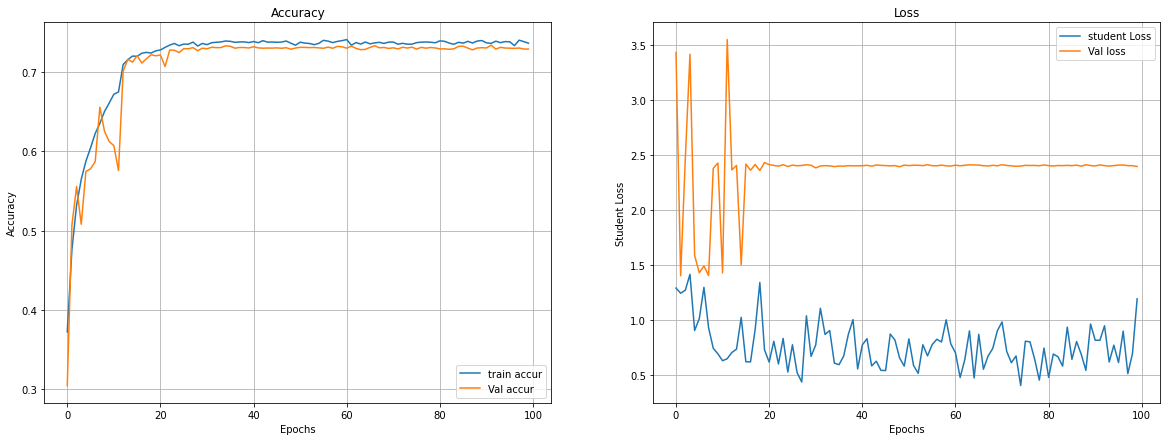

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.2_temp_35/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 103s 60ms/step - sparse_categorical_accuracy: 0.3756 - student_loss: 1.7028 - loss: 0.3501 - val_sparse_categorical_accuracy: 0.4459 - val_student_loss: 3.3499 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 99s 59ms/step - sparse_categorical_accuracy: 0.4890 - student_loss: 1.4137 - loss: 0.2910 - val_sparse_categorical_accuracy: 0.4221 - val_student_loss: 1.2571 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 100s 60ms/step - sparse_categorical_accuracy: 0.5427 - student_loss: 1.2742 - loss: 0.2625 - val_sparse_categorical_accuracy: 0.4273 - val_student_loss: 3.2271 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 100s 60ms/step - sparse_categorical_accuracy: 0.5769 - student_loss: 1.1905 - loss: 0.2453 - val_sparse_categorical_ac

Epoch 33/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7449 - student_loss: 0.7354 - loss: 0.1519 - val_sparse_categorical_accuracy: 0.7383 - val_student_loss: 2.3680 - lr: 1.0000e-04
Epoch 34/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7481 - student_loss: 0.7301 - loss: 0.1509 - val_sparse_categorical_accuracy: 0.7384 - val_student_loss: 2.3547 - lr: 1.0000e-04
Epoch 35/100
1562/1562 [==============================] - 99s 59ms/step - sparse_categorical_accuracy: 0.7441 - student_loss: 0.7400 - loss: 0.1529 - val_sparse_categorical_accuracy: 0.7388 - val_student_loss: 2.3477 - lr: 1.0000e-04
Epoch 36/100
1562/1562 [==============================] - 94s 56ms/step - sparse_categorical_accuracy: 0.7469 - student_loss: 0.7336 - loss: 0.1516 - val_sparse_categorical_accuracy: 0.7403 - val_student_loss: 2.3375 - lr: 1.0000e-04
Epoch 37/100
1562/1562 [==============================] - 98s 58

1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7424 - student_loss: 0.7379 - loss: 0.1524 - val_sparse_categorical_accuracy: 0.7364 - val_student_loss: 2.3493 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 94s 56ms/step - sparse_categorical_accuracy: 0.7447 - student_loss: 0.7363 - loss: 0.1522 - val_sparse_categorical_accuracy: 0.7379 - val_student_loss: 2.3524 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7438 - student_loss: 0.7384 - loss: 0.1525 - val_sparse_categorical_accuracy: 0.7366 - val_student_loss: 2.3307 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 94s 56ms/step - sparse_categorical_accuracy: 0.7468 - student_loss: 0.7326 - loss: 0.1514 - val_sparse_categorical_accuracy: 0.7397 - val_student_loss: 2.3394 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 92s 55ms/step - spa

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.7389 - student_loss: 1.7397

 =============== History Plot ===============


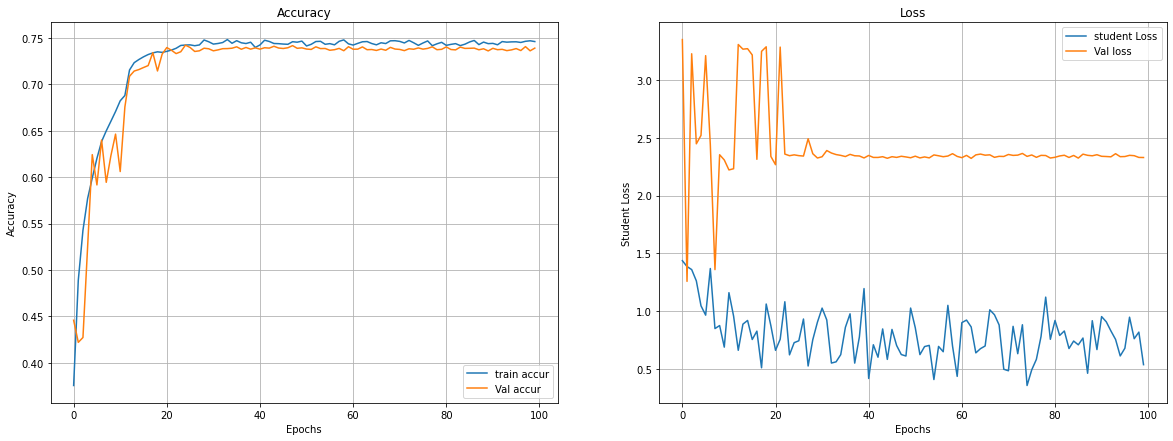

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.2_temp_40/assets
Saving Done !
Saving Weights 
Saving Done !

End !


In [8]:
for t in T:
    # Configuration du tensorboard
    NAME = f"Resnet8_kd_alpha_0.2_temp_{t}"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", histogram_freq = 1)
    
    # Création du resnet 8
    student = resnet_v1(input_shape=(32, 32, 3), depth= 8)

    # Création de l'objet Distiller
    dist = Distiller(teacher, student)
    dist.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        alpha = 0.2,
        temperature = t)

    # Train and evaluate on data.
    hist = dist.fit(datagen.flow(x_train, y_train, 
          batch_size = BATCH_SIZE),
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          callbacks = [lr_reduce, tensorboard],
          )


    dist.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist_kd(hist, f"Resnet8_kd_alpha_0.2_temp_{t}.png")


    print("Saving model ")
    student.save(f"Resnet8_kd_alpha_0.2_temp_{t}")
    print("Saving Done !")

    print("Saving Weights ")
    student.save_weights(f"w_resnet8_temp{t}.h5")
    print("Saving Done !")
    print("")

    print("End !")